In [1]:
import os
import numpy as np
import src.p04_gmm as p04_gmm

import matplotlib.pyplot as plt

from pythetatools.config_visualisation import t2k_style
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

%load_ext autoreload
%autoreload 2

## Problem 1

\begin{align*}
z^{[1]} & = W^{[1]} x + W_0^{[1]} \\
h & = \sigma (z^{[1]}) \\
z^{[2]} & = W^{[2]} h + W_0^{[2]} \\
o & = \sigma (z^{[2]}) \\
L & = \frac{1}{m} \sum_{i = 1}^{m} (o^{(i)} - y^{(i)})^2 = \frac{1}{m} (o - y)^T (o - y) \\
\end{align*}

Using chain rule and tensor denotation one can get:
\begin{align*}
\frac{\partial L}{\partial W^{[L-1]}} = (\sigma^\prime(z^{[L]}) \odot \frac{\partial L}{\partial o})_\nu \sigma^\prime (z_{i\nu}^{[L-1]})a_{j \nu}^{[L-2]} w_i^{[L]} = (W^{[L]} \odot \sigma^\prime(z^{[L-1]})) (\sigma^\prime(z^{[L]}) \odot \frac{\partial L}{\partial o} \odot a^{[L-2]})
\end{align*}

Then for $\frac{\partial L}{\partial w^{1}_{12}}$:

\begin{align*}
\frac{\partial L}{\partial w^{1}_{12}} = \frac{\partial L}{\partial W^{1}_{21}} = \frac{2}{m} w_{2}^2 (h_2 \odot (1 - h_2)) o \odot (1-o) \odot (o-y)\odot x
\end{align*}

In case of step activation function (not linear) it is possible to achieve 100% accuracy (optimal weights are provided in src.p01_nn.py). Basically, you construct the triangle (3 neurons for 3 sides). 

Using linear activation function the $o$ will be linear combination of the inputs $x$. So, the decision boundary will be a straight line for any weights. Thus, 100% accuracy is not possible. 

## Problem 4: EM for Gaussian Mixture Models (unsupervised and semi-supervised)

Running semi-supervised EM algorithm...
Trial 0
-2396.720474744835
-2314.9148786384185
-2167.4953230722635
-2034.7041910820071
-1935.0947074951296
-1860.7987107259237
-1819.688498809278
-1813.0478658165848
-1805.5962034581964
-1797.085024079233
-1794.4841118762497
-1794.0379304371695
-1793.811023706232
-1793.533065570713
-1793.2211662534469
-1792.916234133102
-1792.6437830901034
-1792.413858730803
-1792.2268774157942
-1792.0785139762995
-1791.9627364017972
-1791.873414511523
-1791.8050476980527
-1791.753009902253
-1791.7135561050359
-1791.683726423703
-1791.6612180523657
-1791.6442583149476
-1791.6314925472752
-1791.6218907817313
-1791.614672725882
-1791.609248744427
-1791.6051740867579
-1791.602113726714
-1791.599815532339
-1791.598089886687
-1791.5967942592588
-1791.5958215527135
Trial 1
-2395.018512210866
-2345.916581142178
-2217.1528215609906
-2076.578409606231
-1979.6547497165272
-1912.4213145907302
-1862.4402043710088
-1830.5666266281714
-1807.2295944948542
-1792.2462400447553
-1

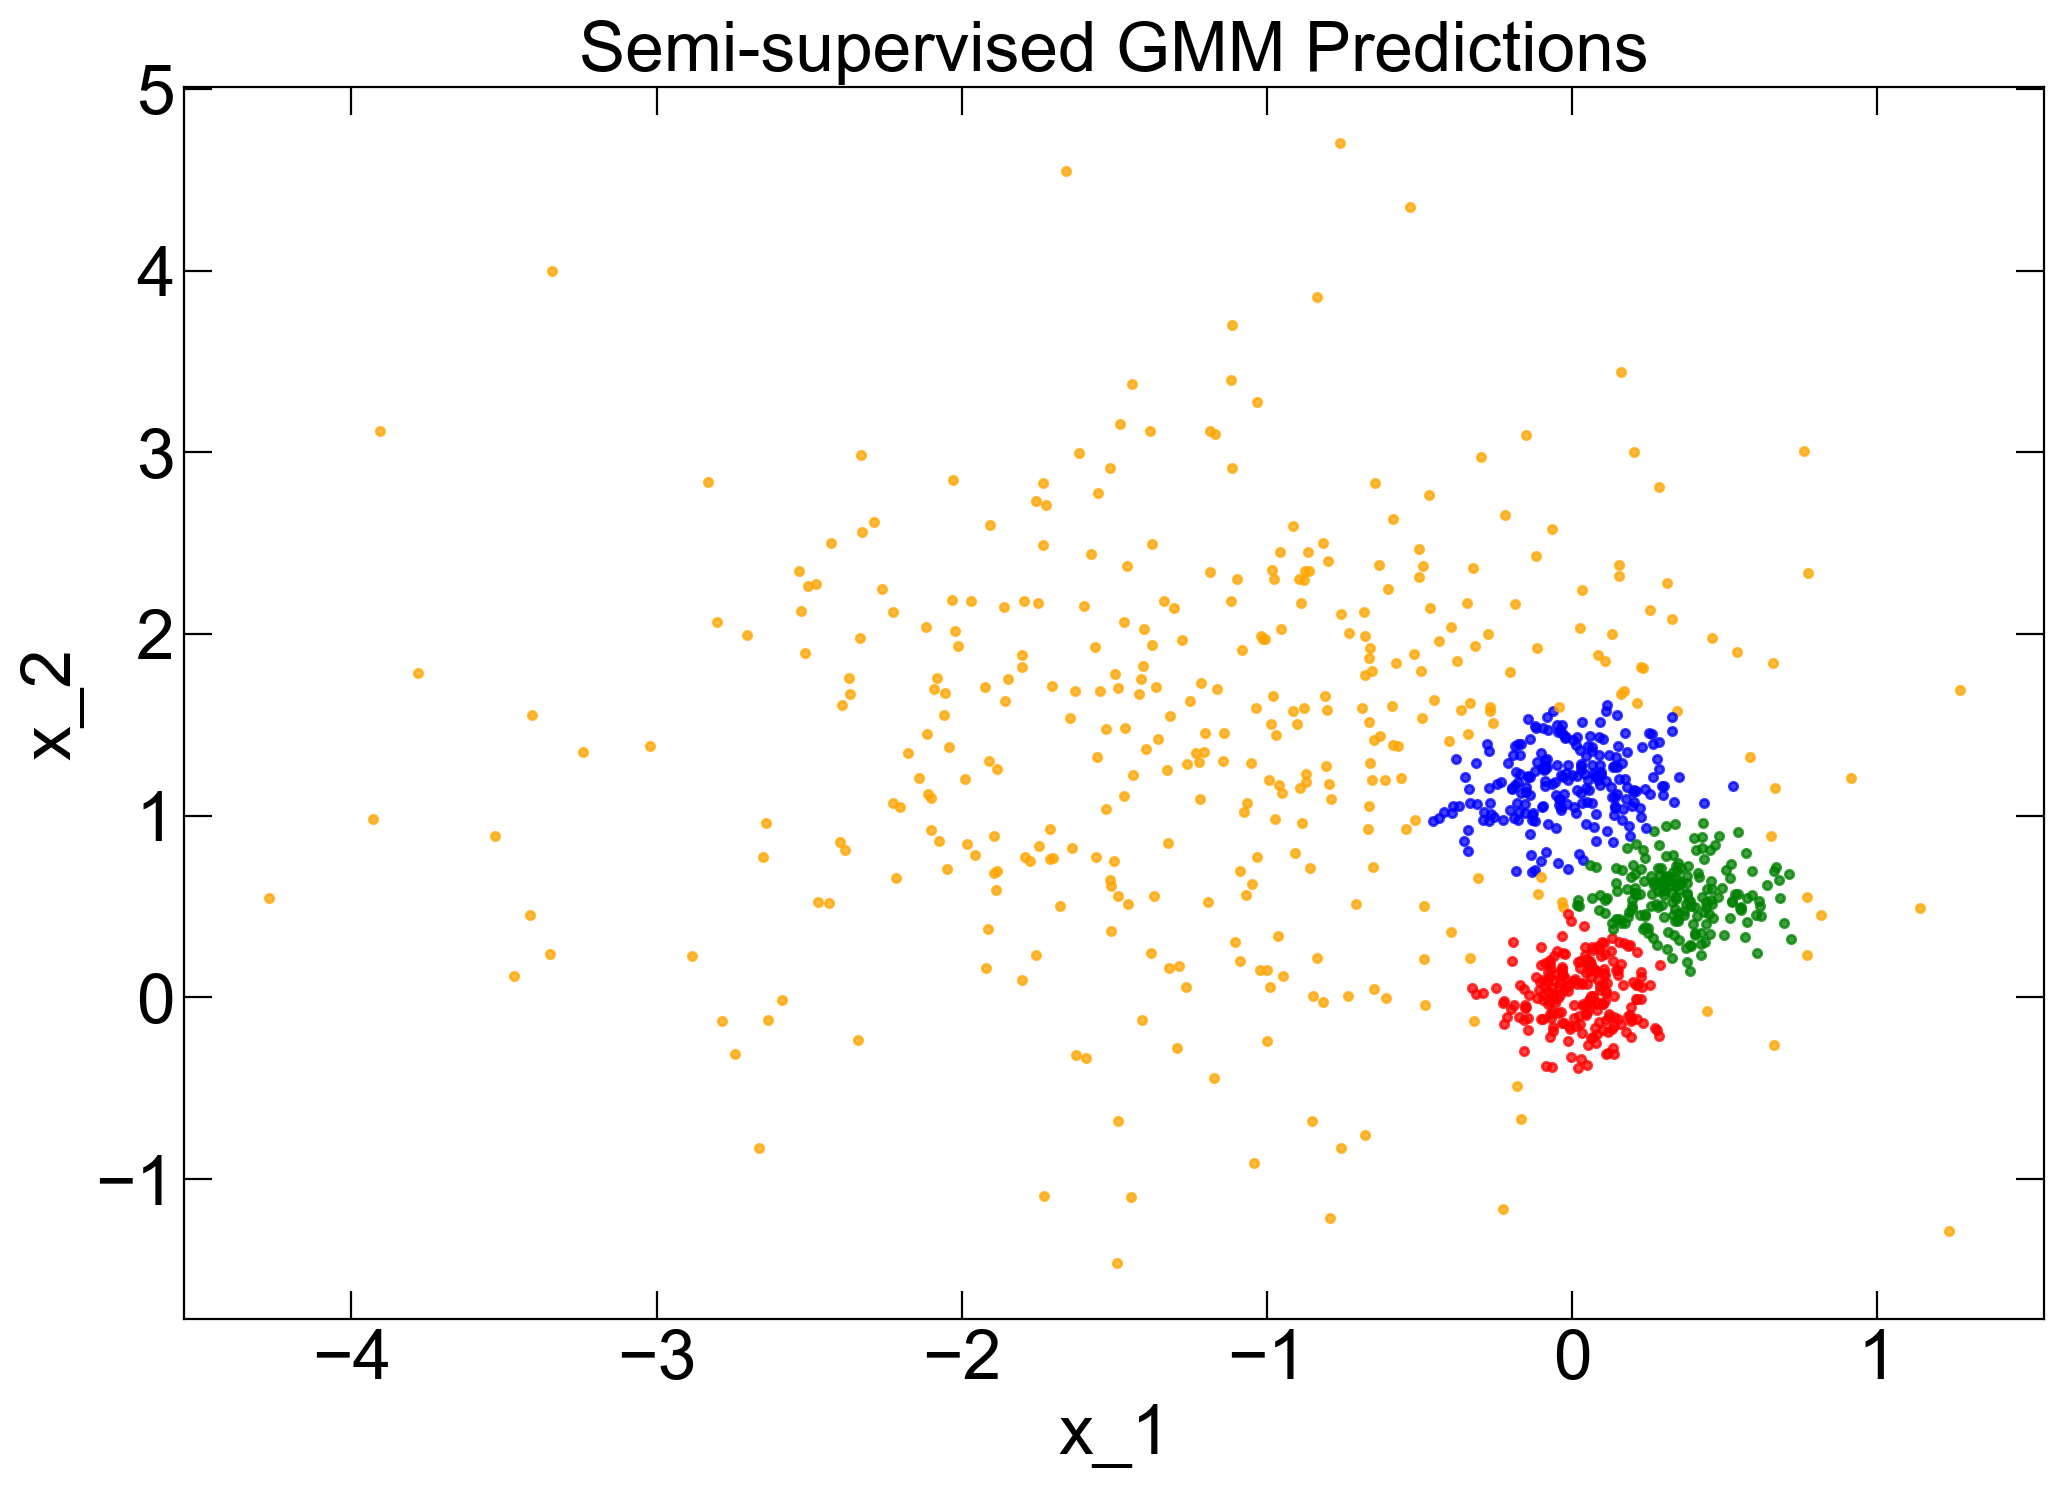

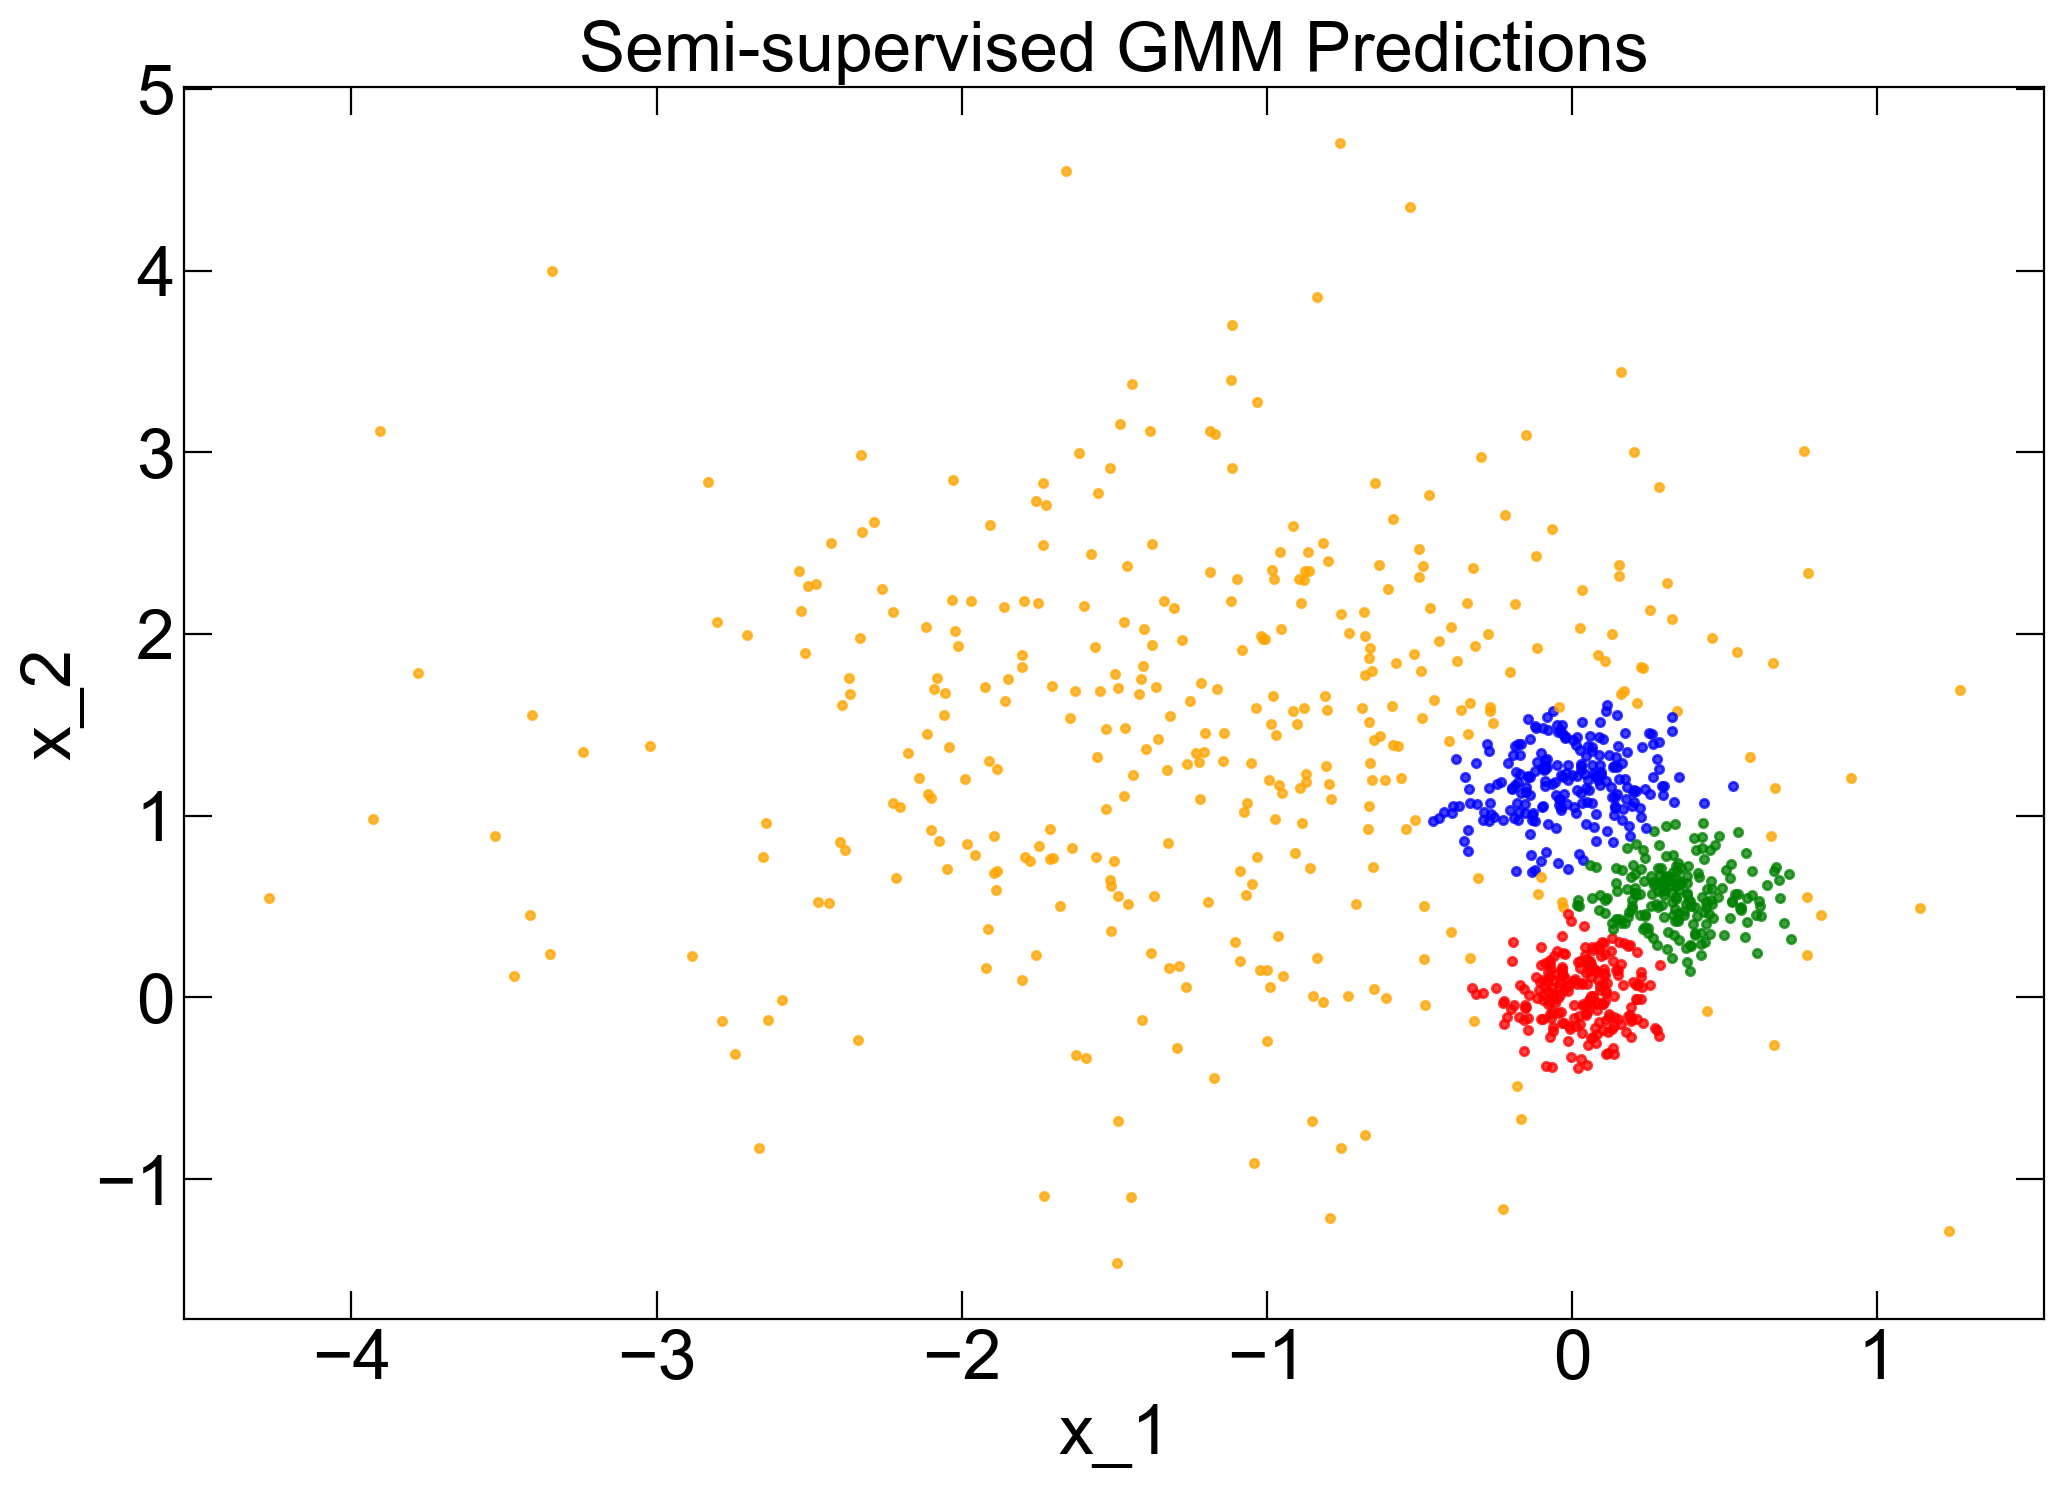

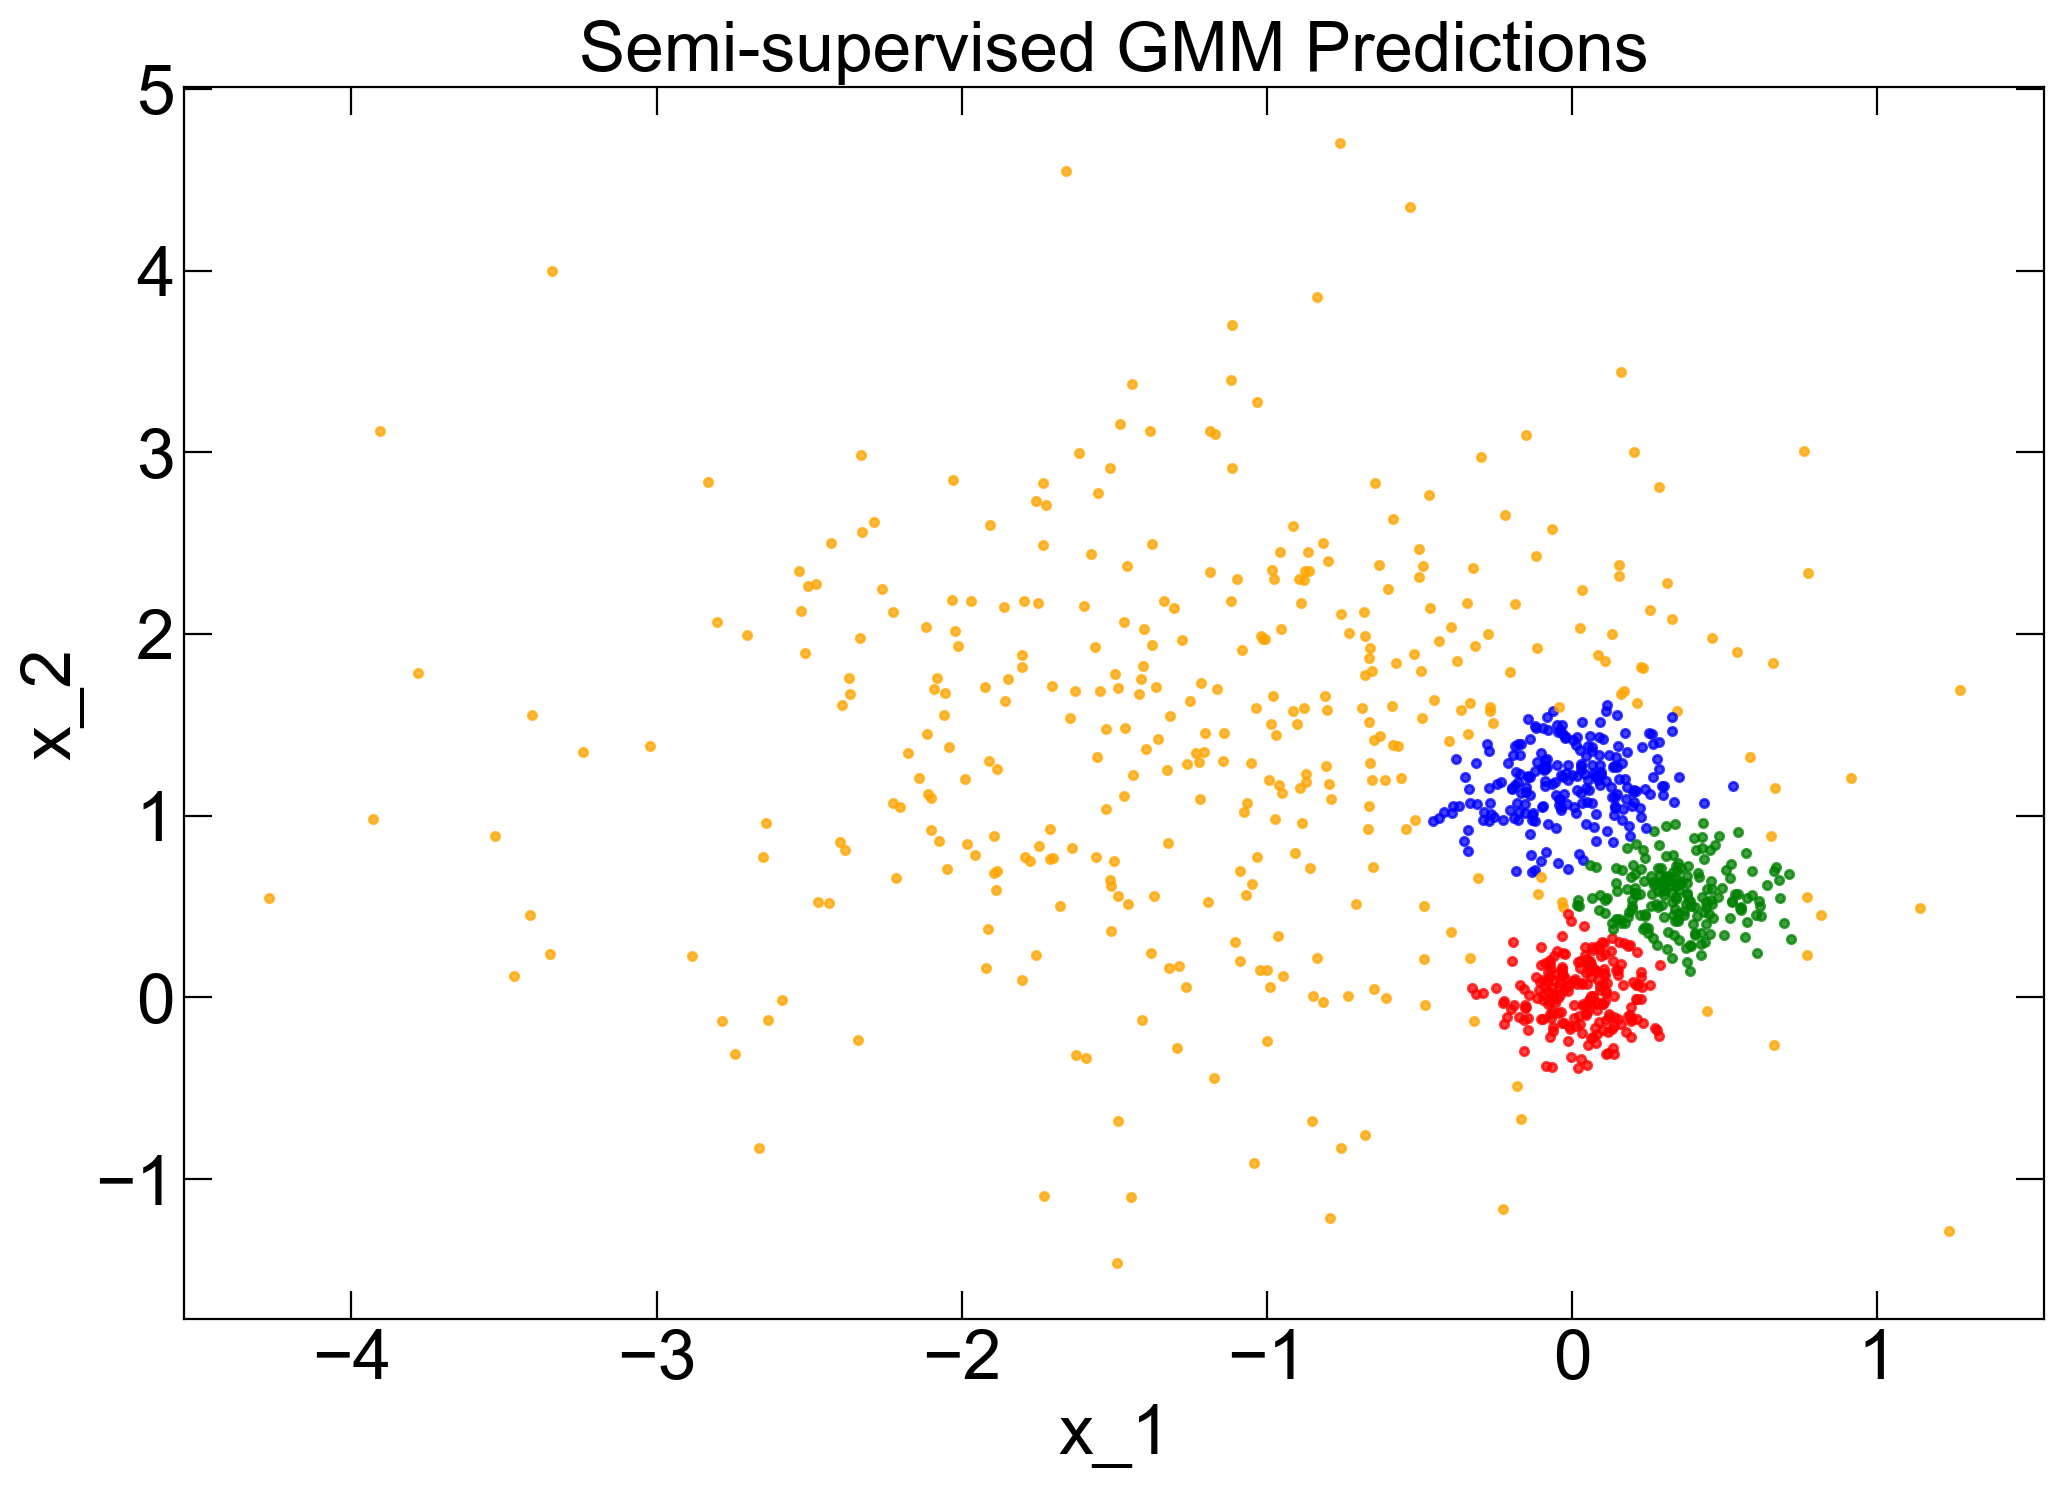

In [70]:
is_semi_supervised = True
smart_init = False

print('Running {} EM algorithm...'.format('semi-supervised' if is_semi_supervised else 'unsupervised'))

# Load dataset
train_path = os.path.join('data', 'ds3_train.csv')
x, z = p04_gmm.load_gmm_dataset(train_path)
x_tilde = None

if is_semi_supervised:
    # Split into labeled and unlabeled examples
    labeled_idxs = (z != p04_gmm.UNLABELED).squeeze()
    x_tilde = x[labeled_idxs, :]   # Labeled examples
    z = z[labeled_idxs, :]         # Corresponding labels
    x = x[~labeled_idxs, :]        # Unlabeled examples

for trial_num  in range(p04_gmm.NUM_TRIALS):
    # *** START CODE HERE ***
    print(f'Trial {trial_num}')
    m, n = x.shape
    mu = []
    sigma = []
    
    if is_semi_supervised and smart_init:
        for j in range(p04_gmm.K):
            mu.append(np.mean(x_tilde[(z==j)[:,0]], axis=0))
            sigma.append(np.cov(x_tilde[(z==j)[:,0]].T))
    else:
        shuffled_pos = np.random.permutation(x)
        parts = np.array_split(shuffled_pos, p04_gmm.K)
        for j in range(p04_gmm.K):
            mu.append(np.mean(parts[j], axis=0))
            sigma.append(np.cov(parts[j].T))
    
    phi = np.ones(p04_gmm.K)/p04_gmm.K
    w = np.ones((m, p04_gmm.K))*phi
    # *** END CODE HERE ***
    
    if is_semi_supervised:
        w = p04_gmm.run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma)
    else:
        w = p04_gmm.run_em(x, w, phi, mu, sigma)
    
    # Plot your predictions
    z_pred = np.zeros(m)
    if w is not None:  # Just a placeholder for the starter code
        for i in range(m):
            z_pred[i] = np.argmax(w[i])
    
    p04_gmm.plot_gmm_preds(x, z_pred, is_semi_supervised, plot_id=trial_num)